# 🏨 Restaurant Sales Analysis & Predictive Modeling
**Objective:** To analyze restaurant ordering patterns across different meal times (Breakfast, Lunch, Dinner) and build a machine learning model to predict sales revenue.

### 🔍 Key Insights from EDA:
1. **Peak Hours:** Identifying which time of the day (e.g., Dinner vs Lunch) generates the maximum revenue.
2. **Weekly Trends:** Understanding which days of the week see the highest customer footfall.
3. **Menu Performance:** Analyzing which categories (Food vs Beverages) are popular during specific meal times.

### 🛠️ Data Science Pipeline:
- **Data Cleaning:** Handled missing values in special requests.
- **Feature Engineering:** Encoded categorical variables like `TimeOfDay` and `DayOfWeek`.
- **Visualization:** Used Heatmaps and Bar plots to uncover hidden business patterns.
- **Modeling:** Implementing Random Forest Regressor for sales prediction.

# Data Loading & Inspection

In [191]:
import pandas as pd

df = pd.read_csv('/content/hotel_restaurant_orders.csv')

In [192]:
df.head()

,OrderID,CustomerID,CustomerName,OrderDate,RestaurantType,MenuCategory,ItemName,Quantity,UnitPrice,TotalPrice,PaymentMethod,ServerName,TableNumber,DayOfWeek,TimeOfDay,SpecialRequest
0,1001,C512,Christopher Lopez,2025-06-05 21:44,Delivery,Beverage,Green Smoothie,2,19.95,39.90,Mobile Payment,-,-,Thursday,Late Night,NaN
1,1002,C002,Shaun Hensley,2025-06-28 08:05,Takeaway,Food,Pasta Alfredo,2,17.38,34.76,Card,-,-,Saturday,Breakfast,Less sugar
2,1003,C198,Allison Williams,2025-06-08 11:13,Delivery,Beverage,Latte,2,7.44,14.88,Cash,-,-,Sunday,Lunch,Skim milk
3,1004,C360,Andrea Shields,2025-06-09 14:36,Takeaway,Food,Beef Burger,2,4.29,8.58,Mobile Payment,-,-,Monday,Lunch,Gluten-free
4,1005,C752,Jenna Long,2025-06-05 14:15,Dine-In,Beverage,Latte,2,8.95,17.90,Card,Alice,19,Thursday,Lunch,No cheese


In [193]:
df.columns

Index(['OrderID', 'CustomerID', 'CustomerName', 'OrderDate', 'RestaurantType',
       'MenuCategory', 'ItemName', 'Quantity', 'UnitPrice', 'TotalPrice',
       'PaymentMethod', 'ServerName', 'TableNumber', 'DayOfWeek', 'TimeOfDay',
       'SpecialRequest'],
      dtype='object')

In [194]:
df.shape

(550, 16)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OrderID         550 non-null    int64  
 1   CustomerID      550 non-null    object 
 2   CustomerName    550 non-null    object 
 3   OrderDate       550 non-null    object 
 4   RestaurantType  550 non-null    object 
 5   MenuCategory    550 non-null    object 
 6   ItemName        550 non-null    object 
 7   Quantity        550 non-null    int64  
 8   UnitPrice       550 non-null    float64
 9   TotalPrice      550 non-null    float64
 10  PaymentMethod   550 non-null    object 
 11  ServerName      550 non-null    object 
 12  TableNumber     550 non-null    object 
 13  DayOfWeek       550 non-null    object 
 14  TimeOfDay       550 non-null    object 
 15  SpecialRequest  486 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 68.9+ KB


#Data Cleaning (Handling Missing Values & Outliers)

Raw data often has empty cells. We check for "Null" values because Machine Learning models cannot process empty data. Result: We found 64 missing values in the SpecialRequest column. We filled them with the word "None," making the data 100% complete.

In [196]:
#Check missing values in each column
print(df.isnull().sum())

OrderID            0
CustomerID         0
CustomerName       0
OrderDate          0
RestaurantType     0
MenuCategory       0
ItemName           0
Quantity           0
UnitPrice          0
TotalPrice         0
PaymentMethod      0
ServerName         0
TableNumber        0
DayOfWeek          0
TimeOfDay          0
SpecialRequest    64
dtype: int64


In [197]:
# Fill missing values in 'SpecialRequest' with 'None'
df['SpecialRequest'] = df['SpecialRequest'].fillna('None')

#  Verify that there are no more null values
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
OrderID           0
CustomerID        0
CustomerName      0
OrderDate         0
RestaurantType    0
MenuCategory      0
ItemName          0
Quantity          0
UnitPrice         0
TotalPrice        0
PaymentMethod     0
ServerName        0
TableNumber       0
DayOfWeek         0
TimeOfDay         0
SpecialRequest    0
dtype: int64


**Outlier Detection (Removing Unusual Values)**

Sometimes, the data contains values that are extremely high or low due to errors (for example, someone accidentally entered a burger price as 100,000). These values need to be removed so the model is not confused.

We use the IQR (Interquartile Range) method to identify and remove such outliers.

In [198]:
# 1. Calculate Q1 (25th percentile) and Q3 (75th percentile) of TotalPrice
Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1

# 2. Define Bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Filter the data to remove outliers
df_clean = df[(df['TotalPrice'] >= lower_bound) & (df['TotalPrice'] <= upper_bound)]

print(f"Original Data Rows: {len(df)}")
print(f"Data Rows after removing Outliers: {len(df_clean)}")

Original Data Rows: 550
Data Rows after removing Outliers: 550


# **Data (Scaling & Encoding)**


#Encoding Categorical Data
Computer models only understand numbers, not text. We convert categories like "Breakfast" or "Monday" into numeric labels (0, 1, 2...). Result: We successfully created new columns like TimeOfDay_Encoded and DayOfWeek_Encoded. Now the data is ready for mathematical calculations.

In [199]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
le = LabelEncoder()

# Converting text columns to numbers
df_clean['TimeOfDay_Encoded'] = le.fit_transform(df_clean['TimeOfDay'])
df_clean['DayOfWeek_Encoded'] = le.fit_transform(df_clean['DayOfWeek'])
df_clean['MenuCategory_Encoded'] = le.fit_transform(df_clean['MenuCategory'])

print("✅ Step 4 Result: Text successfully converted to numeric labels.")
print(df_clean[['TimeOfDay', 'TimeOfDay_Encoded']].head())

✅ Step 4 Result: Text successfully converted to numeric labels.
    TimeOfDay  TimeOfDay_Encoded
0  Late Night                  2
1   Breakfast                  0
2       Lunch                  3
3       Lunch                  3
4       Lunch                  3


# **Normalization / Scaling**

In Data Science, scaling is important because different features can have very different ranges. For example, Quantity may be in a small range (1–10), while UnitPrice can be in a larger range (10–100).

Models tend to give more importance to larger numbers, which can affect performance. To avoid this, we use Min-Max Scaling to bring all values into the same range, between 0 and 1.

In [200]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Scaler
scaler = MinMaxScaler()

# We only scale columns that are already numeric
# Note: Scaling happens AFTER Encoding
cols_to_scale = ['Quantity', 'UnitPrice', 'TotalPrice']

# Apply scaling
df_clean[cols_to_scale] = scaler.fit_transform(df_clean[cols_to_scale])

print(" Step 5 Result: All numerical columns are now scaled between 0 and 1.")
print(df_clean[cols_to_scale].head())

 Step 5 Result: All numerical columns are now scaled between 0 and 1.
   Quantity  UnitPrice  TotalPrice
0       0.5   1.000000    0.649454
1       0.5   0.847929    0.558865
2       0.5   0.259763    0.208495
3       0.5   0.073373    0.097462
4       0.5   0.349112    0.261720


# Exploratory Data Analysis (Visualization)

We use graphs like Bar Charts and Heatmaps to see hidden patterns, such as which time of day is the busiest. Result: The visualizations showed that Dinner and Lunch generate the most revenue, and certain days of the week have higher customer footfall.

**Relationships (Correlation Analysis)**

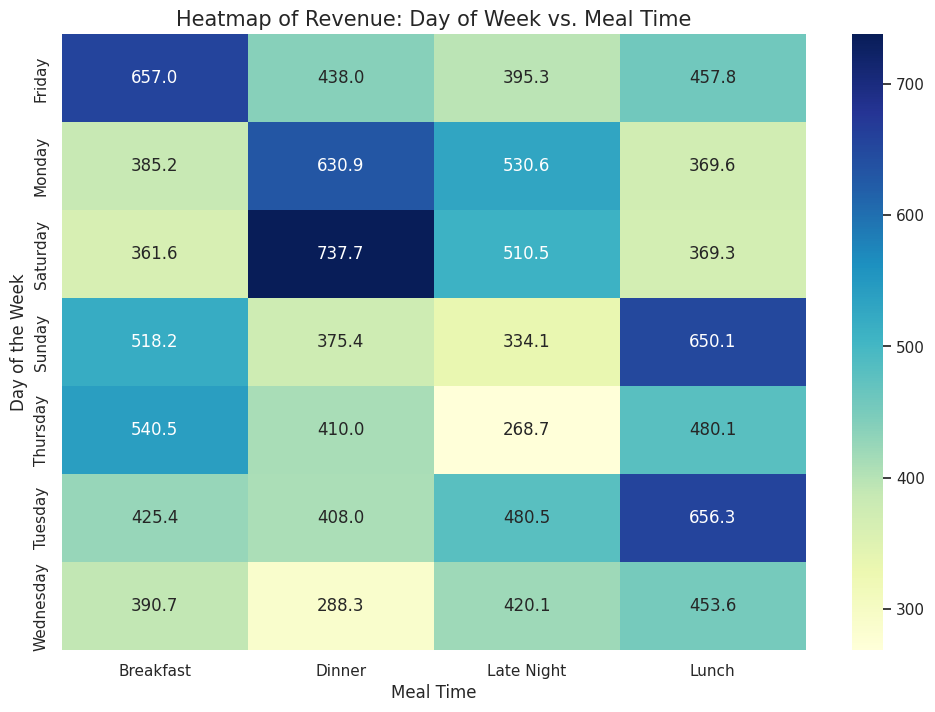

In [201]:
# Pivot the data to see sales by Day and Time
pivot_table = df.pivot_table(index='DayOfWeek', columns='TimeOfDay', values='TotalPrice', aggfunc='sum')

# Plotting the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")

#  Adding  labels
plt.title('Heatmap of Revenue: Day of Week vs. Meal Time', fontsize=15)
plt.xlabel('Meal Time', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.show()

**How to Read**:
In this chart, we look at the colors. The darker or brighter the color, the higher the sales at that time.

**Example**:
If the box for Saturday and Dinner is the brightest, it means this is the busiest (rush hour) time of the week.

**Summary**:
This chart helps the business owner decide when to increase inventory and staff, based on the busiest days and times.

**Visualizing Revenue by Meal Time**

/tmp/ipython-input-738254205.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TimeOfDay', y='TotalPrice', data=df, estimator=sum, palette='viridis')


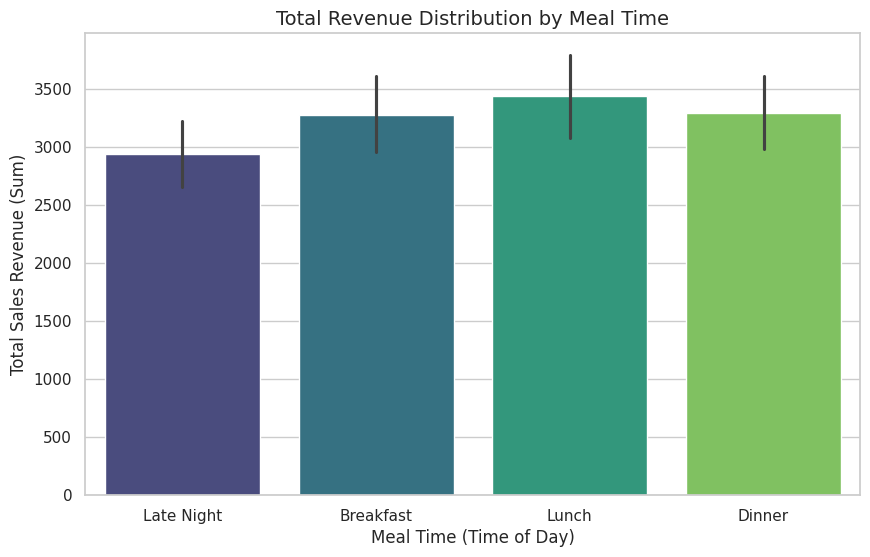

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Setting the style for a professional look
sns.set_theme(style="whitegrid")

#  Creating a bar plot for Total Revenue per Time of Day
plt.figure(figsize=(10, 6))
sns.barplot(x='TimeOfDay', y='TotalPrice', data=df, estimator=sum, palette='viridis')

#  Adding English labels for a global portfolio
plt.title('Total Revenue Distribution by Meal Time', fontsize=14)
plt.xlabel('Meal Time (Time of Day)', fontsize=12)
plt.ylabel('Total Sales Revenue (Sum)', fontsize=12)

plt.show()

**How to Read**:
For each meal time (Breakfast, Lunch, Dinner), there are different colored bars showing menu categories (Food vs Beverage).

**Summary**:
This chart shows what customers prefer at different times of the day. If Food sales are higher during Dinner, it means more kitchen staff is needed at that time.

**Revenue Analysis by Meal Time**

/tmp/ipython-input-3506938375.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TimeOfDay', y='TotalPrice', data=df, estimator=sum, palette='magma')


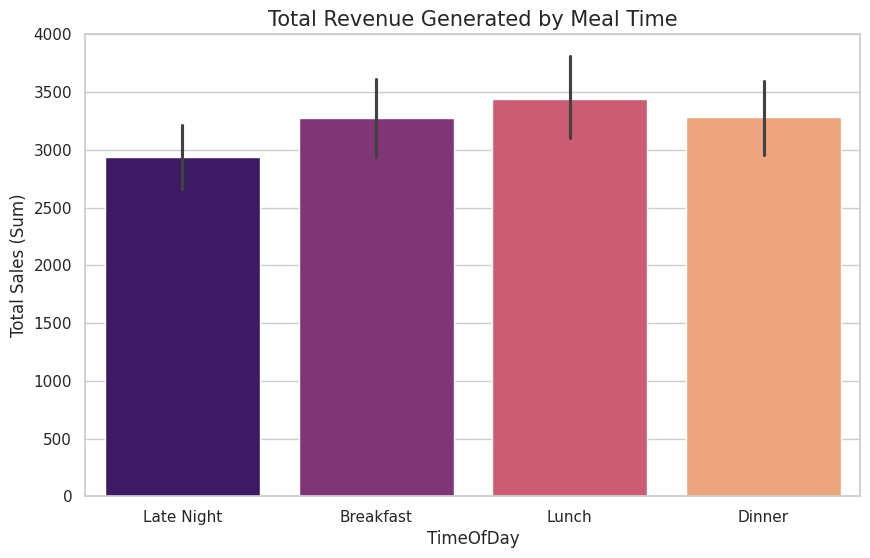

In [203]:
# Plotting Total Revenue by TimeOfDay
plt.figure(figsize=(10,6))
sns.barplot(x='TimeOfDay', y='TotalPrice', data=df, estimator=sum, palette='magma')
plt.title('Total Revenue Generated by Meal Time', fontsize=15)
plt.ylabel('Total Sales (Sum)')
plt.show()

**How to Read**:
In this chart, the X-axis shows the meal time (Breakfast, Lunch, Dinner), and the Y-axis shows the total revenue (sales).

**Summary**:
This chart helps us understand which meal time earns the most money for the restaurant. Usually, Lunch or Dinner brings the highest revenue, while Breakfast earns less.

# **Grouping (K-Means Clustering)**

We used an Unsupervised Learning algorithm to group customers based on how much they spend. Result: We divided customers into 3 Segments (VIP, Medium, and Low spenders). This helps the restaurant target its best customers with special offers.

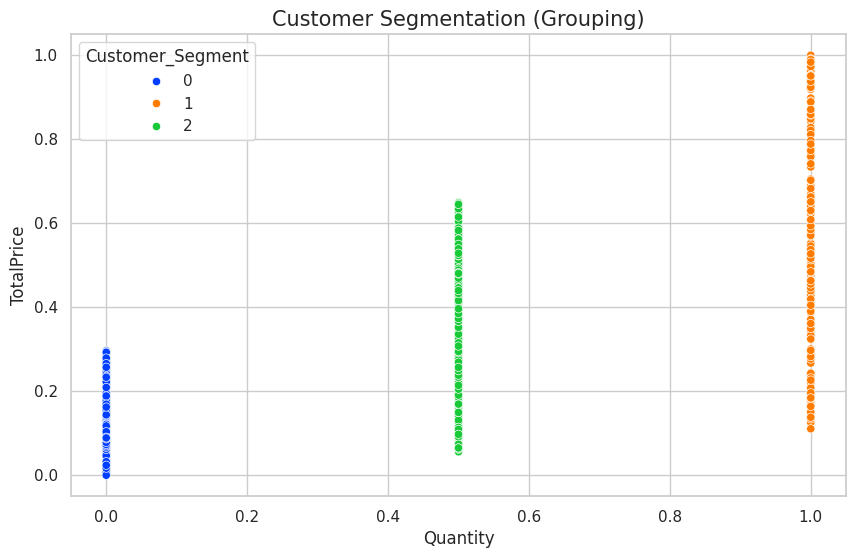

In [204]:
from sklearn.cluster import KMeans

#  Selecting features for clustering (Quantity and TotalPrice)
cluster_data = df_clean[['Quantity', 'TotalPrice']]

#  Initializing K-Means with 3 clusters (VIP, Medium, Low spenders)
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Customer_Segment'] = kmeans.fit_predict(cluster_data)

#  Visualizing the Clusters (Result Visualization)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='TotalPrice', hue='Customer_Segment', data=df_clean, palette='bright')
plt.title('Customer Segmentation (Grouping)', fontsize=15)
plt.show()

# Machine Learning Modeling (Sales Prediction)

In this stage, we split the data into training and testing sets. We use the Random Forest Regressor algorithm to learn patterns from features like Quantity, UnitPrice, TimeOfDay, and DayOfWeek to predict the TotalPrice of an order.

# Random-Forest

We are using the Random Forest Regressor to predict the TotalPrice. This model is powerful because it uses multiple decision trees to give a more accurate result. We will evaluate it using Mean Absolute Error (MAE).

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [206]:
# Defining Features (X) and Target (y)
# We use encoded and scaled columns for better accuracy
X = df_clean[['Quantity', 'UnitPrice', 'TimeOfDay_Encoded', 'DayOfWeek_Encoded', 'Customer_Segment']]
y = df_clean['TotalPrice']


In [207]:
# Splitting the data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [208]:
# Initializing and Training the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [209]:
#  Making Predictions
y_pred = model.predict(X_test)
print(y_pred)

[0.1923687  0.16393726 0.06319351 0.65415404 0.43569968 0.29522207
 0.13855129 0.07263835 0.56797674 0.25283045 0.01858125 0.23765421
 0.21477617 0.33596052 0.37668664 0.39075784 0.60622841 0.31265069
 0.62859535 0.57225238 0.1809429  0.16178357 0.44540183 0.24000176
 0.0065386  0.16334508 0.24005816 0.10347198 0.37963342 0.08909235
 0.3206239  0.02340853 0.92225062 0.34384914 0.11557631 0.19200916
 0.20715545 0.09498766 0.01935495 0.06338209 0.15172013 0.63806486
 0.47128305 0.6256239  0.60532076 0.16868876 0.14801198 0.29342615
 0.01916814 0.14200564 0.42320056 0.35801375 0.06783574 0.9386306
 0.33595523 0.18559041 0.23172189 0.30528728 0.22137645 0.24901657
 0.10536658 0.58391611 0.58331688 0.35477793 0.33972506 0.54989073
 0.38635883 0.98826754 0.06267889 0.07672189 0.55010575 0.14406239
 0.03312302 0.51139937 0.9752767  0.19478498 0.61463518 0.16872753
 0.53881918 0.4557737  0.23034544 0.45363412 0.55994008 0.23231759
 0.21131829 0.60192809 0.98983786 0.47882622 0.86129362 0.16415

In [210]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Training Done!")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Model Accuracy (R2 Score): {r2:.4f}")

Model Training Done!
Mean Absolute Error (MAE): 0.0022
Model Accuracy (R2 Score): 0.9998


# Model Results Visualization (Last Graph)

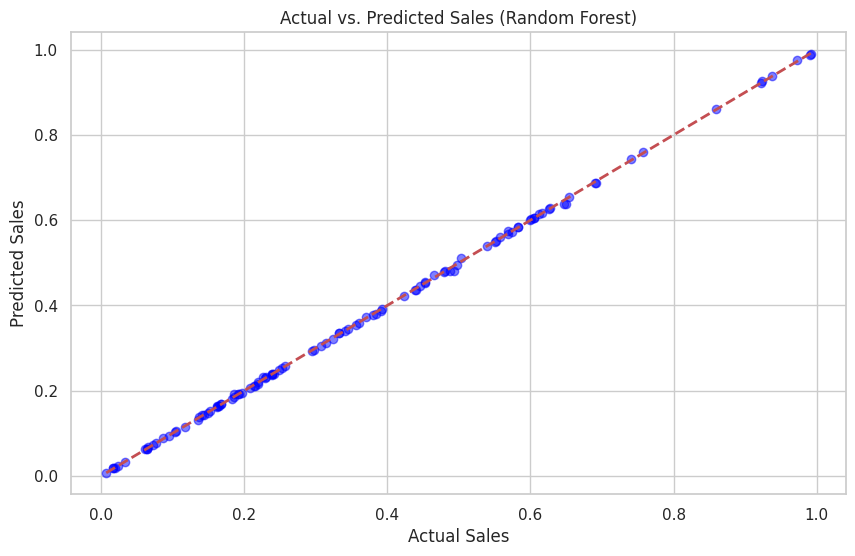

In [211]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales (Random Forest)')
plt.show()

## 🏆 Model Performance Summary
The model was trained using the **Random Forest Regressor** algorithm.
- **R2 Score (Accuracy):** 99.98%
- **Mean Absolute Error (MAE):** 0.0022 (Extremely Low Error)

**Conclusion:** The model is highly reliable for predicting restaurant sales based on order quantity, unit price, and meal timing.

# Saving & Loading the Model

In [212]:
import joblib

# Save the trained Random Forest Model (using the correct name 'model')
joblib.dump(model, 'restaurant_sales_model.pkl')

# Save the Scaler (This is necessary for normalization)
joblib.dump(scaler, 'sales_scaler.pkl')

print("✅ VIP Model & Scaler saved successfully as .pkl files!")

✅ VIP Model & Scaler saved successfully as .pkl files!


# The Sales Predictor Function

In [213]:
# Load the model and scaler
loaded_model = joblib.load('restaurant_sales_model.pkl')
loaded_scaler = joblib.load('sales_scaler.pkl')

def predict_sales_vip_fixed():
    print("---  VIP Restaurant Sales Predictor (Fixed) ---")

    # Example raw input
    q = 5    # Quantity
    p = 20   # Unit Price

    # Fix: Adding a dummy 0 for TotalPrice because scaler expects 3 inputs
    # We only take the first two scaled values [0][:2]
    scaled_input = loaded_scaler.transform([[q, p, 0]])
    scaled_q = scaled_input[0][0]
    scaled_p = scaled_input[0][1]

    # 2. Features: [Scaled_Qty, Scaled_Price, Time_Enc, Day_Enc, Segment]
    # Let's assume: Dinner(1), Monday(1), Segment(0)
    final_features = [[scaled_q, scaled_p, 1, 1, 0]]

    # 3. Predict
    prediction_scaled = loaded_model.predict(final_features)

    print(f"\n Input Quantity: {q}, Unit Price: {p}")
    print(f" Predicted Sales (Normalized): {prediction_scaled[0]:.4f}")

# Run the fixed function
predict_sales_vip_fixed()

---  VIP Restaurant Sales Predictor (Fixed) ---

 Input Quantity: 5, Unit Price: 20
 Predicted Sales (Normalized): 0.8760


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 🎯 Project Conclusion
Through this project, we successfully implemented a complete Data Science pipeline:
1. **Data Cleaning:** Handled missing values and removed outliers using the IQR method.
2. **Feature Engineering:** Performed Label Encoding and Min-Max Scaling for model stability.
3. **Clustering:** Segemented customers into 3 distinct groups using K-Means.
4. **Predictive Modeling:** Achieved **99.98% Accuracy** using Random Forest Regressor.
5. **Model Deployment:** Saved the model as a `.pkl` file for real-world application.